In [92]:
import time
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import CuDNNLSTM,BatchNormalization
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from matplotlib import pyplot as plt
import pickle
import pandas as pd
import lstm
from sklearn.preprocessing import MinMaxScaler,Normalizer,StandardScaler

In [121]:
def rescale_windows(window_data):
    result=scale_windows(window_data)
    #result=norm_windows(window_data)
    #result=log_windows(window_data)
    #result=normalise_windows(window_data)
    #result=standard_windows(window_data)
    return result

def log_windows(window_data):
    return np.log(window_data)
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) if window[0]!=0 else 0 for p in window]
        normalised_data.append(normalised_window)
    return normalised_data
def scale_windows(window_data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(window_data)
    return scaled_values
def norm_windows(window_data):
    scaler = Normalizer()
    scaled_values = scaler.fit_transform(window_data)
    return scaled_values
def standard_windows(window_data):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(window_data)
    return scaled_values

def load_data(seq_len, normalise_window):
    data_list=['Barclays-Noida-3.2-Jan', 'Barclays-Noida-3.2-Feb', 'Barclays-Noida-3.2-March','Barclays-Noida-3.2-April']

    for month in range(len(data_list)):
        month_data=pickle.load(open('../../processed_data/'+data_list[month]+'.p', "rb" ))
        if month==0:
            data=month_data.copy()
        else:
            data=pd.concat([data,month_data])
    data=data.drop(['Country','Department','Resource Type'],axis=1)

    data=data.groupby([data.floor,data.seatName,pd.Grouper(key='Datetime',freq='H')])
    data=data['Space'].agg([np.sum])
    data.reset_index(inplace=True)
    data['isOccupied']=[0 if x <3 else 1 for x in data['sum']]
    data=data.drop(['sum'],axis=1)
    floor_data=data.groupby([data.floor,pd.Grouper(key='Datetime',freq='H')])['isOccupied'].agg([np.sum])
    floor_data.reset_index(inplace=True)
    one_floor=floor_data.loc[floor_data.floor=='Level 9']
    one_floor.set_index('Datetime',inplace=True)
    one_floor.index.freq='H'
    data=np.array(one_floor['sum'])

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = rescale_windows(result)

    result = np.array(result)

    #row = round(0.85 * result.shape[0])
    #row=int(result.shape[0])-168
    row=int(result.shape[0])-336
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [122]:
seq_len=84
pred_len=84
normalize=True
x_train, y_train, x_test, y_test=load_data(seq_len,normalize)
print(x_train.shape,y_train.shape)
print(x_test.shape)

(1787, 84, 1)
(1787, 84, 1)


In [129]:
model=Sequential()
model.add(LSTM(input_dim=1,output_dim=100,return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(200,return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(output_dim=1))
model.add(Activation("linear"))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.fit(x_train, y_train,batch_size=128,epochs=100,validation_split=0.05,verbose=0)

yo


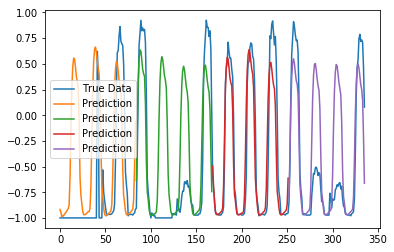

In [130]:
predictions=lstm.predict_sequences_multiple(model,x_test,seq_len,pred_len)
lstm.plot_results_multiple(predictions,y_test,pred_len)

yo


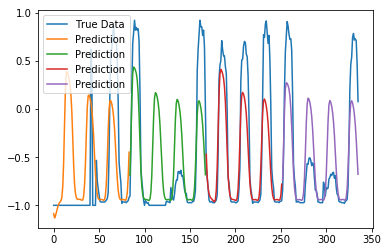

In [128]:
predictions=lstm.predict_sequences_multiple(model,x_test,seq_len,pred_len)
lstm.plot_results_multiple(predictions,y_test,pred_len)